## Harvard CS109b
### Tutorial (2)
### Pan-STARRS SMF Data Format
### Matthew J. Holman, Matthew J. Payne
#### 23 April 2019



In [1]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import random
import itertools
from collections import defaultdict
import importlib
from astropy.io import fits

import ps1_astrom
import ps1_utils

from scipy.optimize import curve_fit
import scipy as sp

import ephem
import healpy as hp

import os
from scipy import spatial
import sqlite3 as lite
import sys
import warnings

from collections import Counter

import socket

import warnings
warnings.filterwarnings('ignore')

# Make the figures bigger
plt.rcParams['figure.figsize'] = [13, 13]

In [2]:
first=lambda x: x[0]
second=lambda x: x[1]

### The Pan-STARRS-1 Data

Rather than searching the Pan-STARRS-1 images themselves, we rely on catalogs of detections extracted from those images by the Image Processing Pipeline (IPP) [reference needed].  The image data comprises petabytes.  Fortunately, the catalogs extracted from those images comprise terabytes.

We have access to 1.3 million smf files. And more are being generated all the time (now on PS1 and PS2).

The Pan-STARRS catalog data from each exposure is stored in a multi-extension FITS files called an 'smf file', so named from its suffix.  I have no idea what 'smf' stands for or if 'file' is redundant, as in 'S M File file'.

There are 182 extensions in a standard smf.  These are:

+ PRIMARY for the overall exposure.  This includes the filter, the time and duration of the exposure, WCS information, and much, much more.  There is only header information for PRIMARY

+ MATCHED_REFS contains information about the referencd stars that were used to determine the astrometric solution and photometric zero point for the overall exposure as well as for each detector.  MATCHED_REFS has both header information and data.  The data is a binary table of the stars used.  It's incredibly useful!

+ For each of the 60 detectors/chips there is an '.hdr' extension, a '.psf' extension, and a '.deteff' extension. 

    - The '.hdr' extension contains header information for that detector.   This includes WCS information, and much much more.

    - The '.psf' extension is a binary table with each row representing a detection returned by the IPP.

    - The '.deteff' extension contains detection efficiency results based on synthetic sources inserted into the detector by the IPP.



Let's explore the structure and content of an smf file.  The fits package in astropy.io makes this very easy.

We can open any FITS file as below.  We get back an collection of HDU (Header-Data Units).

It takes about a second to open an smf file.  We can iterate over the HDUs in various pythonic ways.  (Refer to the astropy documentation for more details.)

We will use the FITS library in astropy for much of this work: 

http://docs.astropy.org/en/stable/io/fits/index.html

In [3]:
from astropy.io import fits

In [5]:
%%time
# Here we use the fits library to open an example smf file named 'o6771g0234o.729155.cm.943415.smf'
smf = '/Users/user/Downloads/o4998g0341o.78361.cm.1163823.smf'
hdus = fits.open(smf)

CPU times: user 4.68 ms, sys: 1.33 ms, total: 6 ms
Wall time: 5.2 ms


 It's handy to have a list of the names of the chips.  They are organized into an x-y grid, with the corners missing.

In [6]:
chips=['XY01', 'XY02', 'XY03', 'XY04', 'XY05', 'XY06',
       'XY10', 'XY11', 'XY12', 'XY13', 'XY14', 'XY15', 'XY16', 'XY17',
       'XY20', 'XY21', 'XY22', 'XY23', 'XY24', 'XY25', 'XY26', 'XY27',
       'XY30', 'XY31', 'XY32', 'XY33', 'XY34', 'XY35', 'XY36', 'XY37',
       'XY40', 'XY41', 'XY42', 'XY43', 'XY44', 'XY45', 'XY46', 'XY47',
       'XY50', 'XY51', 'XY52', 'XY53', 'XY54', 'XY55', 'XY56', 'XY57',
       'XY60', 'XY61', 'XY62', 'XY63', 'XY64', 'XY65', 'XY66', 'XY67',
       'XY71', 'XY72', 'XY73', 'XY74', 'XY75', 'XY76']






# ******* PRIMER ON VARIOUS ASPECTS OF PANSTARRS DATA ********







### Misc. Useful Header Stuff

In [7]:
# Here's a bunch of other stuff.  Not sure where this belongs.

zptObs   = hdus['PRIMARY'].header["ZPT_OBS"]
filterID = hdus['PRIMARY'].header["FILTERID"]
RA       = hdus['PRIMARY'].header["RA"]
Dec      = hdus['PRIMARY'].header["DEC"]
exptime  = hdus['PRIMARY'].header["EXPTIME"]
mjdObs   = hdus['PRIMARY'].header["MJD-OBS"]
airmass  = hdus['PRIMARY'].header["AIRMASS"]
jd = mjdObs + 2400000.5

nans = np.isnan(hdus['XY11.psf'].data['AP_MAG_RAW'])
infs = np.isinf(hdus['XY11.psf'].data['AP_MAG_RAW'])

qfp_thresh=0.1
np.sum(hdus['XY11.psf'].data['PSF_QF_PERFECT']>qfp_thresh)

platescale =  hdus['XY11.psf'].data['PLTSCALE']
ra_sig =  hdus['XY11.psf'].data['X_PSF_SIG']*platescale
dec_sig =  hdus['XY11.psf'].data['Y_PSF_SIG']*platescale
psf_major =  hdus['XY11.psf'].data['PSF_MAJOR']*platescale
psf_minor =  hdus['XY11.psf'].data['PSF_MINOR']*platescale
fwhm_mean = np.sqrt(psf_major*psf_minor)*2.3548

mag0 = hdus['XY11.psf'].data['CAL_PSF_MAG']
mag1 = hdus['XY11.psf'].data['PSF_INST_MAG'] + zptObs + 2.5*math.log10(exptime)
mag_errs = hdus['XY11.psf'].data['PSF_INST_MAG_SIG']

moments_R1=hdus['XY11.psf'].data['MOMENTS_R1']*platescale
psf_QF_perfect=hdus['XY11.psf'].data['PSF_QF_PERFECT']
psf_extent = (moments_R1*moments_R1)/(psf_major*psf_minor)



### Here are the column/fields names for one of the chips
 - The fields used above (X_PSY, Y_PSF, RA_PSF, DEC_PSF, CAL_PSF_MAG, ...) are all present
 - Also of use will be ...

In [8]:
hdus['XY33.psf'].columns

ColDefs(
    name = 'IPP_IDET'; format = '1J'; bscale = 1; bzero = 2147483648
    name = 'X_PSF'; format = '1E'
    name = 'Y_PSF'; format = '1E'
    name = 'X_PSF_SIG'; format = '1E'
    name = 'Y_PSF_SIG'; format = '1E'
    name = 'POSANGLE'; format = '1E'
    name = 'PLTSCALE'; format = '1E'
    name = 'PSF_INST_MAG'; format = '1E'
    name = 'PSF_INST_MAG_SIG'; format = '1E'
    name = 'PSF_INST_FLUX'; format = '1E'
    name = 'PSF_INST_FLUX_SIG'; format = '1E'
    name = 'AP_MAG'; format = '1E'
    name = 'AP_MAG_RAW'; format = '1E'
    name = 'AP_MAG_RADIUS'; format = '1E'
    name = 'AP_FLUX'; format = '1E'
    name = 'AP_FLUX_SIG'; format = '1E'
    name = 'AP_NPIX'; format = '1J'
    name = 'CAL_PSF_MAG'; format = '1E'
    name = 'CAL_PSF_MAG_SIG'; format = '1E'
    name = 'RA_PSF'; format = '1D'
    name = 'DEC_PSF'; format = '1D'
    name = 'PEAK_FLUX_AS_MAG'; format = '1E'
    name = 'SKY'; format = '1E'
    name = 'SKY_SIGMA'; format = '1E'
    name = 'PSF_CHISQ'; format =

# Real Detections 
 - Astrophysical sources (stars, galaxies, asteroids, etc)
 - Either (almost) stationary (stars, galaxies)
 - or follow an understandable trajectory (asteroids, moons, ...) 
 - Have variations in their brightness with time that follow understandle patterns.
 - Have a brightness profile in the  image that spreads out spatially (e.f. across the pixels of the chip) in an understandable way. This is referred to as the Point Spread Function, or "PSF". 

# Bogus Detections 
 - Not astrophysical
 
### Possible types of bogus detections:
 - Sky fluctuations
 - Cosmic rays 
 - Detector artifacts 
 - Internal reflections 
 - Bleeds / Scattered light from bright astrophysical sources 

### Differing attributes:
 - Stationary w.r.t. the camera (e.g. Detector artifacts)
 - Random positions and also random in time (cosmic rays)
 - Near bright stars (bleeds/scattered)
 
### Generally: 
 - Poor PSF
 - Brightness distribution looks completely different to the real/astrophysical sources 

# Numerical Expectations 

 - Expect ~10^5 detections per exposure
 - ~90% will be real, stationary sources (which can be labelled using external functionality)
 - So after removing stationary, ~10^4 detections will remain
 - We anticipate that ~90% of the 10^4 will be BOGUS
 - We anticipate the the remaining 10^3 sources will be Moving (solar system) sources of interest (some known, some unknown) 
 

# Data volume 
- N_Exposures ~ 10^6
- N_detections per exposure ~10^5 (as above) => 10^11 detections total 
- Detection-File (smf) Size ~10^8 bytes => 10^14 bytes total, i.e. ~100Tb


# Coordinate Systems
 - X, Y on the chips / detectors / camera 
 - RA,Dec on the sky 
 - Relating the two ...

##### RA,Dec positions of the detections on the sky 


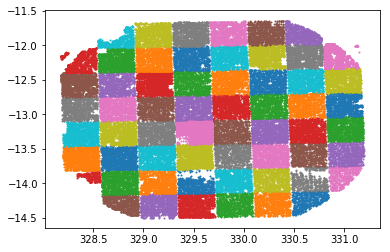

In [12]:
for chip in chips:
    extension_name = chip+'.psf'
    hdu = hdus[extension_name]
    _=plt.scatter(hdu.data['RA_PSF'], hdu.data['DEC_PSF'], s=1)
    


#### X,Y pixel positions of the detections on the detectors
 - Note that the X,Y values are *FOR EACH CHIP* so the ~60 different cells are all being plotted on top of one another 

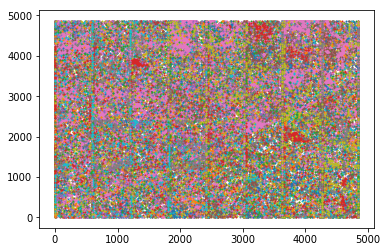

In [13]:

for chip in chips:
    extension_name = chip+'.psf'
    hdu = hdus[extension_name]
    _=plt.scatter(hdu.data['X_PSF'], hdu.data['Y_PSF'], s=1)
    


#### Overly Simplistic Approach: 
 - in the visualization below, the chip data are folded (as in the first tutorial) 
 - the over-density along the edges could be brutally chopped-out, but this will excluded some fraction of the real data
 - can a pixel-by-pixel approach allow us to label noisy PIXELS as opposed to noisey REGIONS of the detector? 

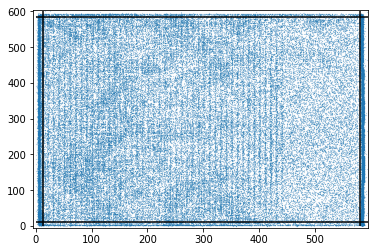

In [14]:
# Need to defend against missing extensions.
x, y = [],[]
for chip in chips:
    x += list(hdus[chip+'.psf'].data['X_PSF'])
    y += list(hdus[chip+'.psf'].data['Y_PSF'])
plt.scatter(ps1_utils.foldx(x), ps1_utils.foldy(y), s=0.01)
plt.xlim(-5,595)
plt.ylim(-5,603)
plt.hlines((10, 585), 0,600)
plt.vlines((12, 580), 0,600)
plt.rcParams['figure.figsize'] = [23, 23]

# Minimise False Negatives
 - False positives can be tollerated (I.e. including some bogus detections as real)
 - We would prefer to minimize the false positives (i.e. we don't want to reject real detections, as they could be some awesome undiscovered object) 

# Magnitudes 
 - Some of the magnitudes are "Nan" so we need to get rid of them 
 - THen we can plot the magnitude distribution of all of the detections

In [15]:
# Get rid of nans...
def x_not_nan(x):
    return x[~np.isnan(x)]

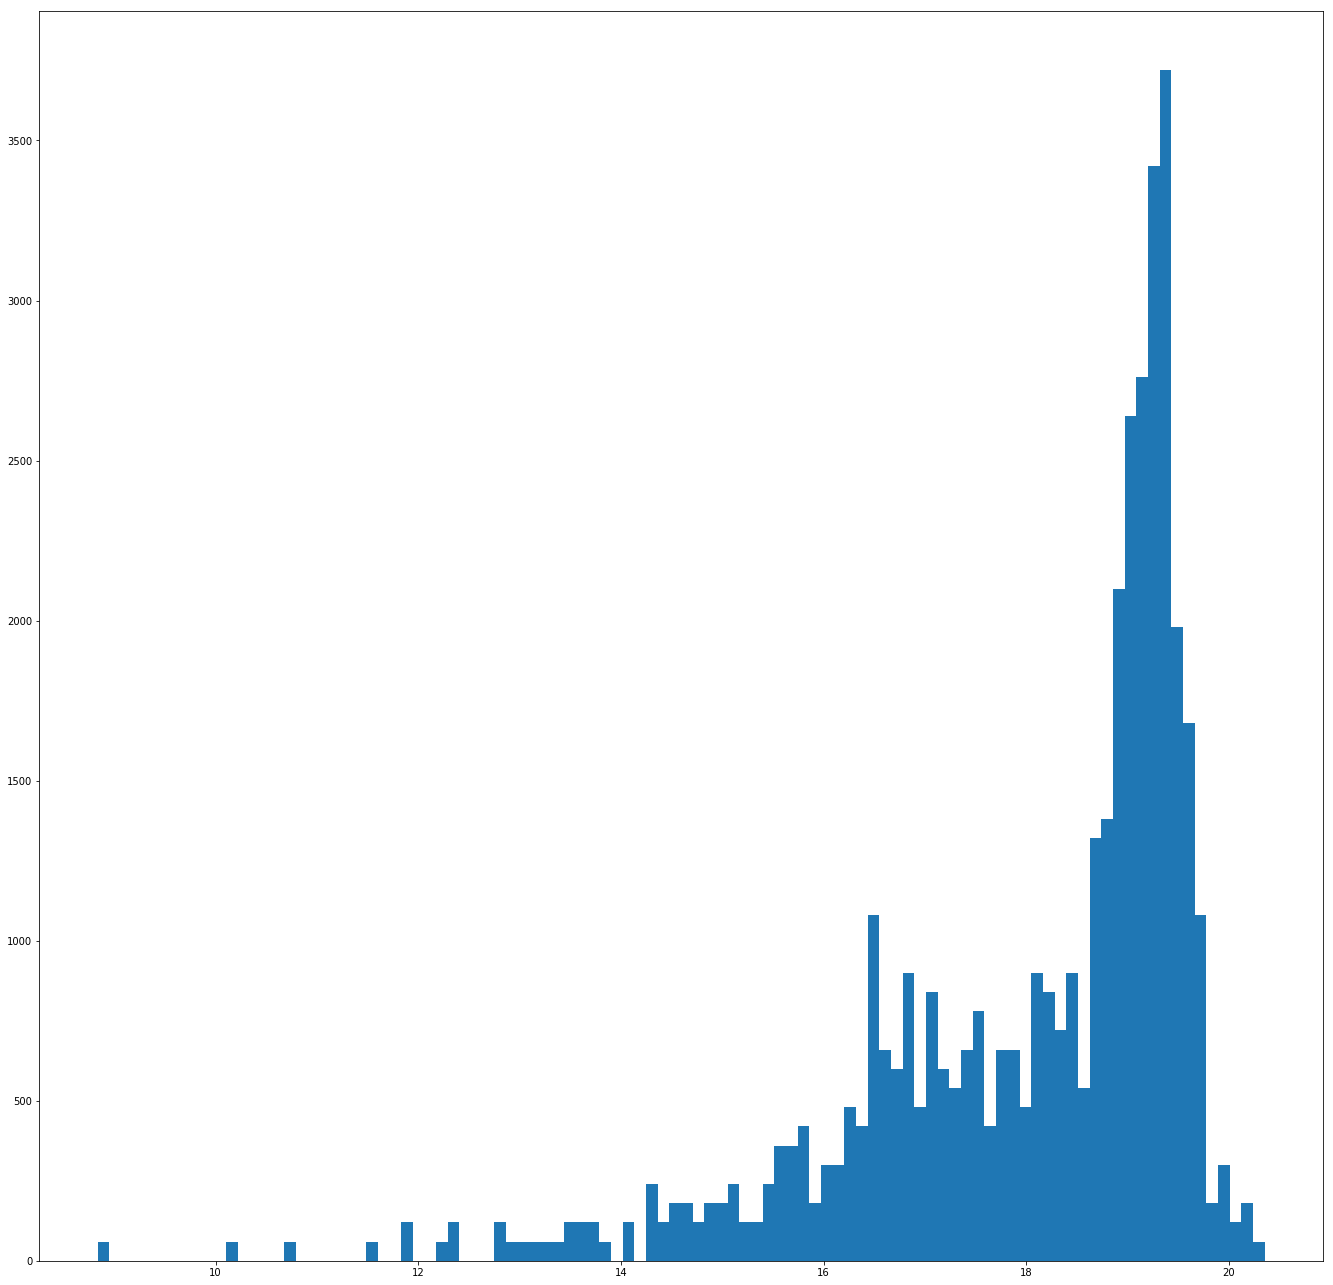

In [16]:
mags = []
for chip in chips:
    extension_name = 'XY01.psf'
    hdu = hdus[extension_name]
    
    mags.append( x_not_nan(hdu.data['CAL_PSF_MAG']) )
    
_=plt.hist( np.concatenate(mags) , bins=100 )

### Notes on magnitudes ...
 - mag = hdus['XY33.psf'].data['PSF_INST_MAG'] + 2.5*np.log10(exptime) + zpt_obs
 - see below 

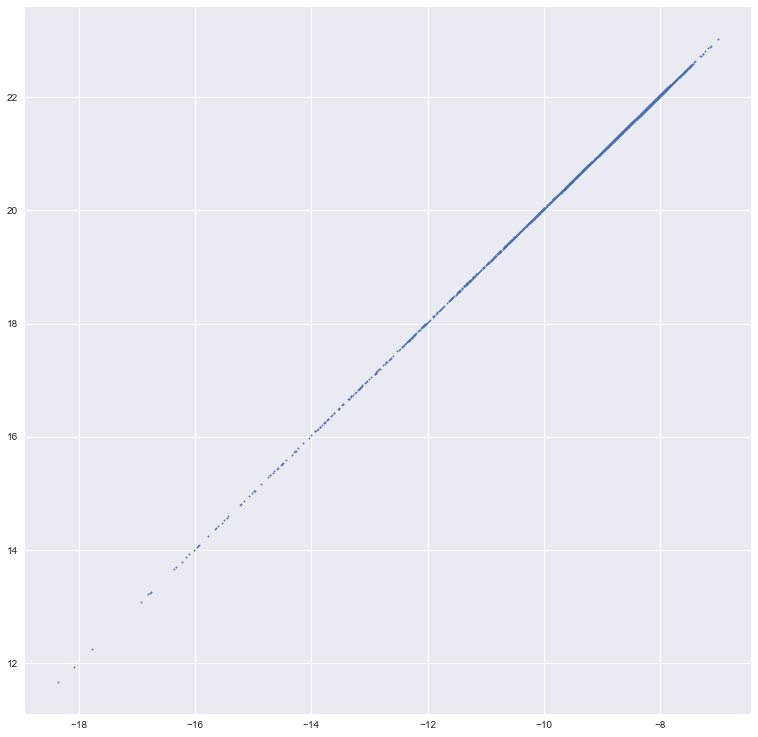

In [0]:
plt.scatter(hdus['XY33.psf'].data['PSF_INST_MAG'] , hdus['XY33.psf'].data['CAL_PSF_MAG'], s=2)

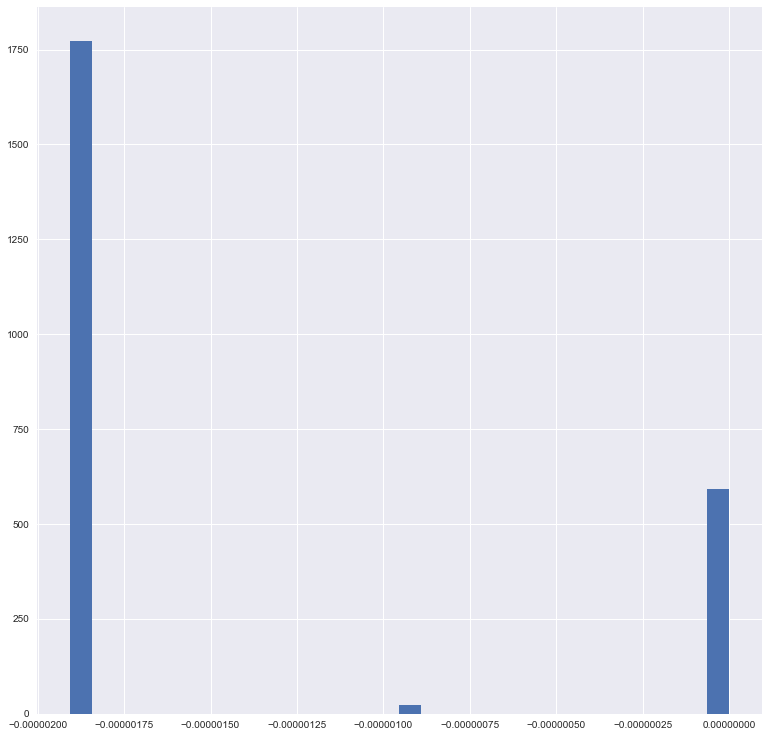

In [0]:

exptime = hdus['primary'].header['EXPTIME']
zpt_obs = hdus['primary'].header['ZPT_OBS']
mag = x_not_nan(hdus['XY33.psf'].data['PSF_INST_MAG'] + 2.5*np.log10(exptime) + zpt_obs)
cal = x_not_nan(hdus['XY33.psf'].data['CAL_PSF_MAG'])

_=plt.hist( cal - mag , bins = 30)


# Flags 

As the IPP is run on Pan-STARRS images and sources are extracted, a large number of characteristics are recorded along the basic properties of each detection (Magnier et al. 2016).  Many of these are binary (yes/no) conditions that are encoded in bitmasks.  These are useful because they constitute potential features in a real-bogus analysis (references).

From Magnier et al (2016), I have extracted two tables that describe meaning of each in the FLAGS and FLAGS2 valaus

https://arxiv.org/pdf/1612.05244



In [0]:
flags_dict = {}
with open('FLAGS.txt') as file:
    for line in file:
        line = line.rstrip()
        if line.startswith('#'):
            continue
        else:
            name    = line[0:20].strip()
            flag    = int(line[20:30], 0)
            comment = line[32:-1]
            flags_dict[flag] = (name, comment)
            
flags2_dict = {}
with open('FLAGS2.txt') as file:
    for line in file:
        line = line.rstrip()
        if line.startswith('#'):
            continue
        else:
            name    = line[0:22].strip()
            flag    = int(line[22:33], 0)
            comment = line[34:-1]
            flags2_dict[flag] = (name, comment)
flags_dict

{1: ('PSFMODEL', 'Source fitted with a psf model (linear or non-linear)'),
 2: ('EXTMODEL', 'Source fitted with an extended-source model'),
 4: ('FITTED',
  'Source fitted with non-linear model (PSF or EXT; good or bad)'),
 8: ('FAIL', 'Fit (non-linear) failed (non-converge, off-edge, run to zero)'),
 16: ('POOR',
  'Fit succeeds, but low-SN, high-Chisq, or large (for PSF -- drop?)'),
 32: ('PAIR', 'Source fitted with a double psf'),
 64: ('PSFSTAR', 'Source used to define PSF model'),
 128: ('SATSTAR', 'Source model peak is above saturation'),
 256: ('BLEND', 'Source is a blend with other sources$^1$'),
 512: ('EXTERNAL', 'Source based on supplied input position'),
 1024: ('BADPSF', "Failed to get good estimate of object's PSF"),
 2048: ('DEFECT', 'Source is thought to be a defect'),
 4096: ('SATURATED', 'Source is thought to be saturated pixels (bleed trail)'),
 8192: ('CR_LIMIT', 'Source has crNsigma above limit'),
 16384: ('EXT_LIMIT', 'Source has extNsigma above limit'),
 32768: (

In [0]:
# Don't want any of these to be set.
bad_flags = 8 + 16 + 128 + 2048 + 4096 + 8192 + 32768 + 65536 + 131072 + 262144 + 268435456 + 536870912 + 1073741824 + 2147483648
for k,v in flags_dict.items():
    if k & bad_flags != 0:
        print(v)

('SATURATED', 'Source is thought to be saturated pixels (bleed trail)')
('FAIL', 'Fit (non-linear) failed (non-converge, off-edge, run to zero)')
('SATSTAR', 'Source model peak is above saturation')
('POOR', 'Fit succeeds, but low-SN, high-Chisq, or large (for PSF -- drop?)')
('ON_SPIKE', 'peak lands on diffraction spike')
('SKY_FAILURE', 'could not measure the local sky')
('SKYVAR_FAILURE', 'could not measure the local sky variance')
('ON_GHOST', 'peak lands on ghost or glint')
('BELOW_MOMENTS_SN', 'moments not measured due to low S/N.$^1$')
('CR_LIMIT', 'Source has crNsigma above limit')
('DEFECT', 'Source is thought to be a defect')
('SIZE_SKIPPED', 'size could not be determined$^1$')
('OFF_CHIP', 'peak lands off edge of chip')
('MOMENTS_FAILURE', 'could not measure the moments')


##### Use bitwise operator to flag the things that are OK (i.e. that do NOT match the bad-flags)


In [0]:
def flags_ok(x, mask=hex(bad_flags)):
    return x & mask == 0

# What components are bad?
def find_components(target):
    return [ i for i in sorted(flags_dict.keys()) if i & target & bad_flags ]
    
target = np.min(hdu.data['FLAGS'])
flags = find_components( target ) 
for i in flags: print(i, flags_dict[i])

2048 ('DEFECT', 'Source is thought to be a defect')
8192 ('CR_LIMIT', 'Source has crNsigma above limit')


##### Use bitwise operator to flag & plot the things that are good/bad 

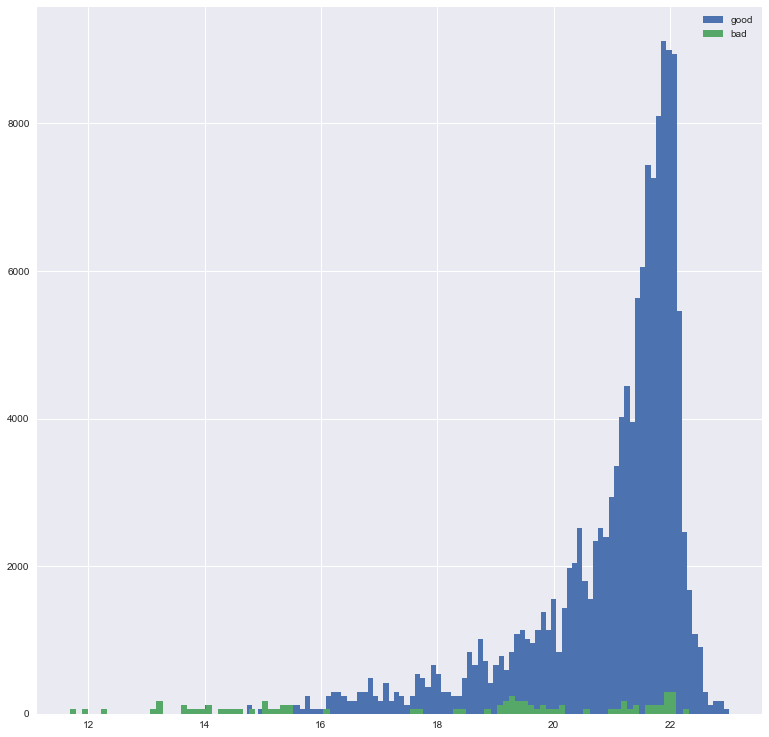

In [0]:
mags_good, mags_bad = [],[]
for chip in chips:
    extension_name = 'XY33.psf'
    hdu = hdus[extension_name]
    indx_flg_ok = flags_ok(hdu.data['FLAGS'], bad_flags) 

    mags_good.append( x_not_nan(hdu.data['CAL_PSF_MAG'][ indx_flg_ok] ) )
    mags_bad.append( x_not_nan(hdu.data['CAL_PSF_MAG'][~indx_flg_ok]) )
    
_=plt.hist( np.concatenate(mags_good) , bins=100 , label='good')
_=plt.hist( np.concatenate(mags_bad) , bins=100 , label='bad')
plt.legend()

# Previous Machine Learning Approach(es)
 - Gradient Boost Classifier
 - Random Forest Classifier 
 
 ### Important Features:
 Filter  y
           Feature   Relative Importance
      PSF_QF_PERFECT  0.383
                 snr  0.275
            CR_LIMIT  0.097
           PSF_THETA  0.000
                 SKY  0.009
               X_PSF  0.082
           X_PSF_SIG  0.011
               Y_PSF  0.049
           Y_PSF_SIG  0.013
           EXT_LIMIT  0.067
       NONLINEAR_FIT  0.003
           PASS1_SRC  0.010
Filter  i
           Feature   Relative Importance
      PSF_QF_PERFECT  0.223
                 snr  0.367
            CR_LIMIT  0.074
           PSF_THETA  0.000
                 SKY  0.028
               X_PSF  0.109
           X_PSF_SIG  0.018
               Y_PSF  0.059
           Y_PSF_SIG  0.043
           EXT_LIMIT  0.057
       NONLINEAR_FIT  0.010
           PASS1_SRC  0.014
Filter  r
           Feature   Relative Importance
      PSF_QF_PERFECT  0.359
                 snr  0.115
            CR_LIMIT  0.088
           PSF_THETA  0.000
                 SKY  0.025
               X_PSF  0.131
           X_PSF_SIG  0.040
               Y_PSF  0.022
           Y_PSF_SIG  0.135
           EXT_LIMIT  0.079
       NONLINEAR_FIT  0.002
           PASS1_SRC  0.004
Filter  z
           Feature   Relative Importance
      PSF_QF_PERFECT  0.402
                 snr  0.273
            CR_LIMIT  0.075
           PSF_THETA  0.000
                 SKY  0.032
               X_PSF  0.096
           X_PSF_SIG  0.007
               Y_PSF  0.038
           Y_PSF_SIG  0.018
           EXT_LIMIT  0.049
       NONLINEAR_FIT  0.002
           PASS1_SRC  0.008
Filter  g
           Feature   Relative Importance
      PSF_QF_PERFECT  0.174
                 snr  0.318
            CR_LIMIT  0.088
           PSF_THETA  0.000
                 SKY  0.117
               X_PSF  0.090
           X_PSF_SIG  0.025
               Y_PSF  0.016
           Y_PSF_SIG  0.094
           EXT_LIMIT  0.072
       NONLINEAR_FIT  0.005
           PASS1_SRC  0.002

# Labelled Data
 - External functionality and data sources will allow you to label (a) stationary sources, and (b) some of the known moving sources
 - Further tutorial notebooks will be provided 